In [ ]:
#@title Download the dataset and extract
%cd /content/
!gdown --id 1iOHX9MIcBDJvHYuyBGqNi-0vposQqFxw
!unzip titanic.zip
%rm -rf titanic.zip

/content
Downloading...
From: https://drive.google.com/uc?id=1iOHX9MIcBDJvHYuyBGqNi-0vposQqFxw
To: /content/titanic.zip
100% 34.9k/34.9k [00:00<00:00, 59.1MB/s]
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
#@title import necessary library
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pyplot import figure
from IPython.display import clear_output
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,InputLayer
from tensorflow.keras.utils import plot_model,model_to_dot
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
figsize = (6,4)

Train shape (891, 12)


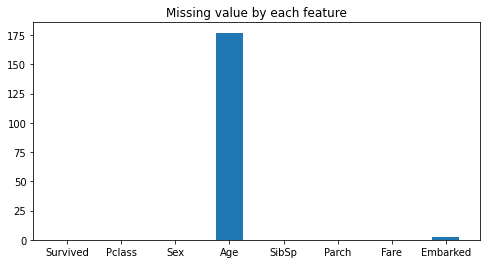

In [ ]:
#@title Read dataset
train = pd.read_csv('train.csv')
drop_columns = ['PassengerId','Name','Cabin','Ticket']
# drop_columns = ['PassengerId','Name','Ticket']
print('Train shape',train.shape)
train.drop(columns=drop_columns,inplace=True)
columns = train.columns
list_nan = list(train.isna().sum())
plt.figure(figsize=(8,4))
plt.bar(columns,list_nan,0.5)
plt.title('Missing value by each feature')
plt.savefig('missing.png')
plt.show()

In [ ]:
X = train[columns]
X.drop(columns=['Survived'],inplace=True)
Y = train['Survived']
c_factorize = columns[1:]
for c in c_factorize:
  val = train[c]
  X[c] = val.factorize()[0]

X = X.to_numpy()
Y = Y.to_numpy()


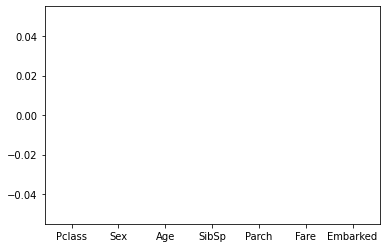

In [ ]:
def imputDataFrame(pd):
  imputer = KNNImputer(n_neighbors=2, weights="uniform",missing_values=-1)
  return imputer.fit_transform(pd)

X = imputDataFrame(X)
df_temp = pd.DataFrame(X)
df_temp = list(df_temp[df_temp==-1].sum())
plt.figure(figsize=figsize)
plt.bar(columns[1:],df_temp,0.5)
plt.show()
del df_temp
X = MinMaxScaler().fit_transform(X)

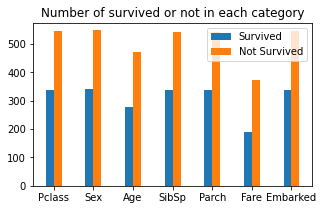

In [ ]:
col_used = list(columns[1:])
X_axis = np.arange(len(col_used))

y_sur = []
y_not = []

for idx,c in enumerate(col_used):
    df_dup = train[[c,'Survived']]
    n,s = df_dup[df_dup.duplicated()]['Survived'].value_counts()
    y_sur.append(s)
    y_not.append(n)
plt.figure(figsize=(5,3))
plt.bar(X_axis - 0.1, y_sur, 0.2, label = 'Survived')
plt.bar(X_axis + 0.1, y_not, 0.2, label = 'Not Survived')
plt.xticks(X_axis, col_used)
plt.title("Number of survived or not in each category")
plt.legend()
plt.savefig('chart_sur_or_not.png',bbox_inches="tight")
plt.show()


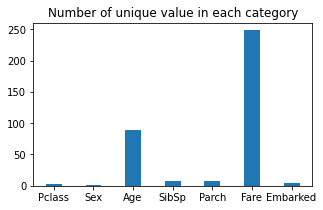

In [ ]:
unique_train = []
for c in col_used:
  l = len(train[c].unique())
  # print(c,l)
  unique_train.append(l)

plt.figure(figsize=(5,3))
plt.bar(col_used,unique_train,0.4)
plt.title('Number of unique value in each category')
plt.savefig('chart_unique.png',bbox_inches="tight")
plt.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=1/3, random_state=42)

In [ ]:
print("Traning")
print('X_train',X_train.shape)
print('Y_train',Y_train.shape)
print("Test")
print('X_test',X_test.shape)
print('Y_test',Y_test.shape)
print("Validation")
print('X_val',X_val.shape)
print('Y_val',Y_val.shape)

Traning
X_train (623, 7)
Y_train (623,)
Test
X_test (178, 7)
Y_test (178,)
Validation
X_val (90, 7)
Y_val (90,)


In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
input_shape = X.shape[1]
model = Sequential()
model.add(InputLayer(input_shape=input_shape))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.predict(np.array([X_train[1]]))
# plot_model(model,show_shapes=True)

array([[0.49429214]], dtype=float32)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])
history = model.fit(X_train, Y_train,validation_data=(X_val,Y_val), epochs=100, batch_size=16)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accuracy.png',bbox_inches="tight")
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png',bbox_inches="tight")
plt.show()

In [ ]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['f1', 'val_f1'], loc='upper right')
plt.savefig('f1.png',bbox_inches="tight")
plt.show()

In [ ]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['precision', 'val_precision'], loc='upper right')
plt.savefig('precision.png',bbox_inches="tight")

plt.show()

In [ ]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['recall', 'val_recall'], loc='upper right')
plt.savefig('recall.png',bbox_inches="tight")

plt.show()

In [ ]:
loss,accuracy,f1,precision,recall = model.evaluate(X_test,Y_test)
print("model_relu")
print("loss:",loss)
print("accuracy:",accuracy)
print("f1:",f1)
print("precision:",precision)
print("recall:",recall)

In [ ]:
# model.save('model.h5',save_format='h5')